In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn import functional as F
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
DATA_PATH = '../data/'

In [3]:
df = pd.read_csv(f'{DATA_PATH}final_data.csv')

In [4]:
df.head()

,actual_words,act,activity,alter,assemblage,be,change,cover,form,give,...,POS_TAG_ADV,POS_TAG_AUX,POS_TAG_CCONJ,POS_TAG_INTJ,POS_TAG_NOUN,POS_TAG_NUM,POS_TAG_PROPN,POS_TAG_SCONJ,POS_TAG_VERB,POS_TAG_X
0,abbreviation,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,abduction,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,ability,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,ablate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,abound,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
def _load_glove_model(File='../models/glove_6B/glove.6B.50d.txt'):
    print("Loading Glove Model")
    gloveModel = {}
    with open(File,'r', encoding="utf8") as f: 
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
GLOVE_MODEL = _load_glove_model()

Loading Glove Model
400000  words loaded!


In [6]:
def _get_word_embeddings(word):
    return GLOVE_MODEL.get(word, None)

In [7]:
df['GLOVE.6B'] = df["actual_words"].apply(_get_word_embeddings)

In [8]:
x_data = df.loc[:, df.columns == 'GLOVE.6B']
y_data = df.loc[:, df.columns == 'move']

In [9]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(s_df):
    device = get_device()
    return Variable(torch.Tensor(s_df.values)).to(device)

def complex_df_to_tensor(_df):
    device = get_device()
    temp_x = []
    for index, row in _df.iterrows():
        temp_row = []
        row = row.to_dict()
        g_em = []
        for key in row.keys():
            if key != 'GLOVE.6B':
                temp_row.append(row[key])
            else:
                g_em = Variable(torch.Tensor(row[key])).to(device)
        temp_x.append(torch.cat([
            Variable(torch.Tensor(temp_row)).to(device), 
            g_em]
            ,dim=0))

    return torch.stack(temp_x, 0)

In [10]:
y_data = df_to_tensor(y_data)
x_data = complex_df_to_tensor(x_data)

In [11]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred
    
model = LogisticRegression(50, 1)

In [12]:
criterion = torch.nn.BCELoss(size_average=True)

C:\Users\acqua\miniconda3\envs\ce\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
model.cuda()

train_loss = []
for epoch in range(5000):
    model.train()
    # Forward pass
    y_pred = model(x_data)
     # Compute Loss
    loss = criterion(y_pred, y_data)
    
    train_loss.append(loss.item())
    
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    optimizer.step()
    

C:\Users\acqua\miniconda3\envs\ce\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
y_pred = model(x_data)

In [16]:
y_data = y_data.cpu().detach().numpy() 
x_data = x_data.cpu().detach().numpy() 
y_pred = y_pred.cpu().detach().numpy() 

In [17]:
y_pred_labels = []
for p in y_pred:
    if p < 0.5:
        label = 0
    else:
        label = 1
    y_pred_labels.append(label)

In [18]:
accuracy_score(y_data, y_pred_labels)

0.8562584118438762

In [19]:
from sklearn.metrics import f1_score

f1_score = f1_score(y_data, y_pred_labels, average='micro')

print(f1_score)

0.8562584118438762


In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_data, y_pred)

0.7057446750653598

In [21]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_data, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7057446750653598

Text(0, 0.5, 'True Positive Rate')

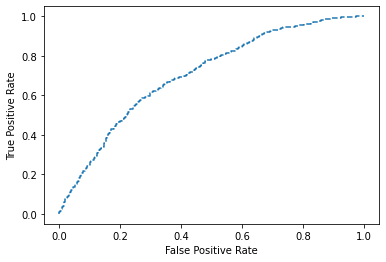

In [22]:
from matplotlib import pyplot

pyplot.plot(fpr, tpr, linestyle='--', label='Move')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

In [23]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_data, y_pred)

Text(0, 0.5, 'Precision')

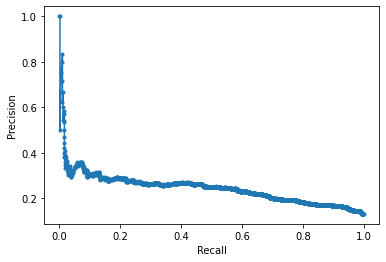

In [24]:
pyplot.plot(recall, precision, marker='.', label='move')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')